# Reproduction of the paper of Weitz et al.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Figure 1

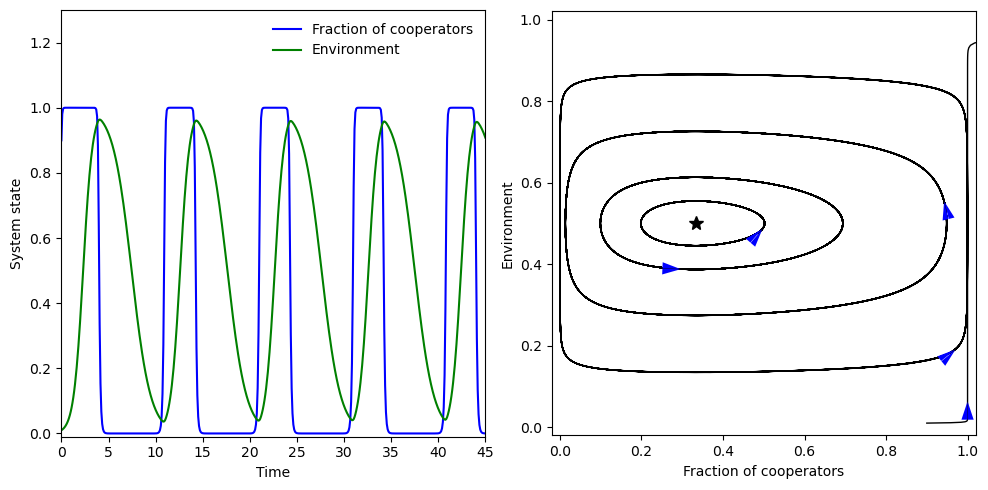

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    x, n = y
    delta_PS = P - S
    delta_TR = T - R
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    return [dxdt, dndt]

def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # Matches the smooth curves in Fig 2A
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    method="BDF",
                    t_eval=np.linspace(0, 45, 500),
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.10, rtol=1e-7, atol=1e-11) #7, 11
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)

    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    initial_conditions = [(0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)]
    
    for ic in initial_conditions:
        # Reduced t_span to 25 to show clean loops (avoiding overlapping lines)
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 50), ic, 
                              method="BDF",
                              t_eval=np.linspace(0, 50, 1000),
                              args=(epsilon, theta, R, S, T, P),
                              max_step=0.01, rtol=1e-3, atol=1e-5) #
        
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=1.0)
        
        # Add directional arrows
        idx = len(sol_orbit.t) // 4
        x_curr, n_curr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_curr, n_curr], epsilon, theta, R, S, T, P)
        norm = np.hypot(dx, dn)
        ax.arrow(x_curr, n_curr, dx/norm*0.001, dn/norm*0.001, 
                 shape='full', lw=0, length_includes_head=True, 
                 head_width=0.03, color='blue', zorder=5)

    # Plot Fixed Point (Asterisk from Fig 2B)
    fixed_x = 1.0 / (1.0 + theta)
    fixed_n = 0.5
    ax.plot(fixed_x, fixed_n, 'k*', markersize=10)

    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal') # Matches the square aspect ratio of the paper figure
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

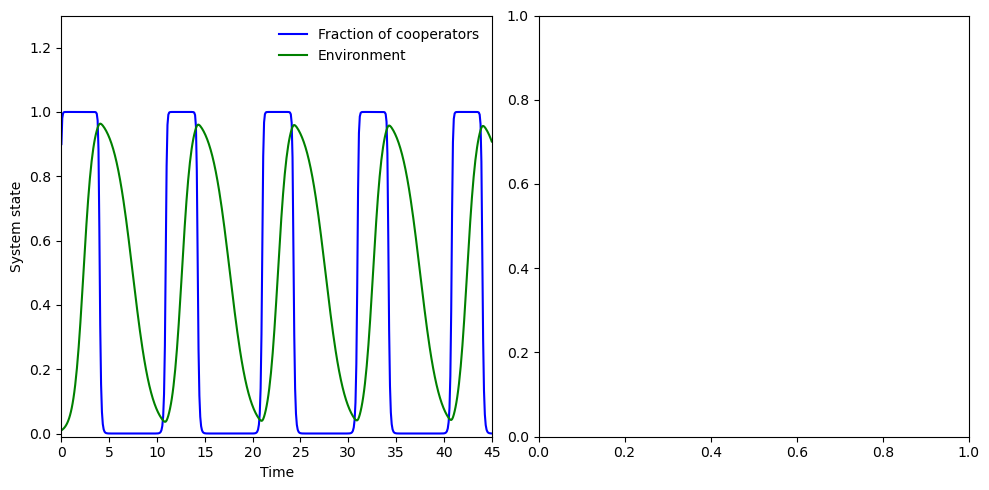

In [37]:
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # Matches the smooth curves in Fig 2A
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    method="BDF",
                    t_eval=np.linspace(0, 45, 500),
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.10, rtol=1e-7, atol=1e-11) #7, 11
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()